In [ ]:
import pandas as pd
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline  
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
import numpy as np
from sklearn.model_selection import GridSearchCV

# Task 1

In [126]:
data_pred = pd.read_csv('Data_PCLab5_Private/Data_PCLab5_pred.csv')
data_tt = pd.read_csv('Data_PCLab5_Private/Data_PCLab5_train_test.csv')
data_tt

,industry,credit_score,year,turnover,year_creation,total_actif,id,total_asset,net_total_asset,margin,...,stable_debt,financial_debt,tot_debt,investment,ppe,intangible,ppent,sales,capital,nbemp
0,47,3,2016,1.793,2006.0,1951,1479243776825,2120.0,1951.0,0.588608,...,335.0,336.0,560.0,7.0,217.0,0,380.0,1793.0,1588.0,4.0
1,68,6,2012,0.037,2003.0,365,1353691776396,530.0,365.0,0.000000,...,0.0,592.0,603.0,0.0,508.0,0,673.0,37.0,508.0,0.0
2,47,5+,2016,1.899,2004.0,1730,1359587200964,1805.0,1730.0,0.000000,...,180.0,206.0,423.0,0.0,76.0,0,151.0,1899.0,1373.0,0.0
3,55,4,2004,1.085,2000.0,1945,1296533120972,2559.0,1945.0,0.000000,...,888.0,1235.0,1499.0,13.0,1587.0,0,2061.0,1085.0,2018.0,3.0
4,59,5+,2012,1.350,1996.0,2372,1229382656899,3020.0,2372.0,0.250000,...,57.0,320.0,915.0,26.0,113.0,0,197.0,1350.0,2093.0,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,47,4+,2008,2.177,1981.0,1115,968708416945,1265.0,1115.0,0.000000,...,25.0,216.0,777.0,0.0,193.0,0,334.0,2177.0,270.0,15.0
49996,71,4+,2016,2.771,2000.0,2862,1295590912908,3315.0,2862.0,-0.203240,...,585.0,949.0,1548.0,278.0,342.0,0,407.0,2771.0,520.0,9.0
49997,68,4+,2007,0.126,1998.0,148,1245545600914,183.0,148.0,0.916667,...,0.0,66.0,73.0,0.0,0.0,0,0.0,126.0,35.0,0.0
49998,46,5,2016,9.670,1991.0,5807,1148055808983,6314.0,5807.0,-0.011514,...,44.0,44.0,4715.0,7.0,190.0,0,339.0,9670.0,573.0,35.0


In [127]:
data_tt['credit_score'].value_counts()

credit_score
5+     12030
4      10249
4+      6804
5       6477
3       4445
6       4237
3+      2820
3++     1415
7        514
8        480
P        386
9        143
Name: count, dtype: int64

In [128]:
data_tt.nunique()

industry              85
credit_score          12
year                  13
turnover           12081
year_creation        162
total_actif        11446
id                 50000
total_asset        12977
net_total_asset    11451
margin             33794
wcr                 6012
sfc                15292
bank_debt           4049
bank_debt_lt        3669
other_debt           385
tot_debt1           9200
tot_debt2           7848
equity1             9047
equity2              361
stable_debt         4149
financial_debt      5838
tot_debt            9229
investment          2319
ppe                 7034
intangible             1
ppent               8619
sales              12110
capital             9300
nbemp                716
dtype: int64

#### Creating new columns

In [ ]:
def add_credit_features(df):
    df = df.copy()
    # Age
    df['company_age'] = df['year'] - df['year_creation']
    df['company_age'] = df['company_age'].clip(lower=0)  
    
    # Leverage / structure
    eps = 1e-9
    df['debt_over_assets'] = df['tot_debt'] / (df['total_asset'] + eps)
    df['fin_debt_over_assets'] = df['financial_debt'] / (df['total_asset'] + eps)
    df['bank_debt_over_assets'] = df['bank_debt'] / (df['total_asset'] + eps)
    df['equity_over_assets'] = df['equity1'] / (df['total_asset'] + eps)
    
    # Liquidity / efficiency
    df['wcr_over_sales'] = df['wcr'] / (df['sales'] + eps)
    df['sfc_over_sales'] = df['sfc'] / (df['sales'] + eps)
    df['asset_turnover'] = df['sales'] / (df['total_asset'] + eps)
    
    # Investment intensity
    df['inv_over_assets'] = df['investment'] / (df['total_asset'] + eps)
    df['ppe_over_assets'] = df['ppe'] / (df['total_asset'] + eps)
    df['ppent_over_assets'] = df['ppent'] / (df['total_asset'] + eps)

    df['debt_to_equity'] = df['tot_debt'] / (df['equity1'] + df['equity2'] + 1e-6)
    df['margin_ratio'] = df['margin'] / (df['sales'] + 1e-6)
    df['investment_ratio'] = df['investment'] / (df['total_asset'] + 1e-6)

    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    return df

data_tt = add_credit_features(data_tt)

#### Dropping irrelevant columns

In [130]:
data_tt = data_tt.drop(columns=['id', 'intangible'])

In [131]:
categorical_cols = ['credit_score', 'industry']
data_tt['credit_score'] = data_tt['credit_score'].astype('category')
data_tt['industry'] = data_tt['industry'].astype('category')
numerical_cols = [col for col in data_tt.columns if col not in categorical_cols]

#### Checking for outliers

In [132]:
num = data_tt.select_dtypes(include="number")

Q1  = num.quantile(0.25, numeric_only=True)
Q3  = num.quantile(0.75, numeric_only=True)
IQR = Q3 - Q1
IQR

year                        5.000000
turnover                    2.628000
year_creation              17.000000
total_actif              2322.000000
total_asset              3015.000000
net_total_asset          2318.000000
margin                      0.265455
wcr                       262.000000
sfc                       198.790000
bank_debt                 293.000000
bank_debt_lt              204.000000
other_debt                  0.000000
tot_debt1                1446.000000
tot_debt2                1062.250000
equity1                   915.000000
equity2                     0.000000
stable_debt               299.000000
financial_debt            597.000000
tot_debt                 1446.000000
investment                 45.000000
ppe                       796.000000
ppent                    1272.000000
sales                    2628.000000
capital                  1462.000000
nbemp                      15.000000
company_age                18.000000
debt_over_assets            0.411166
f

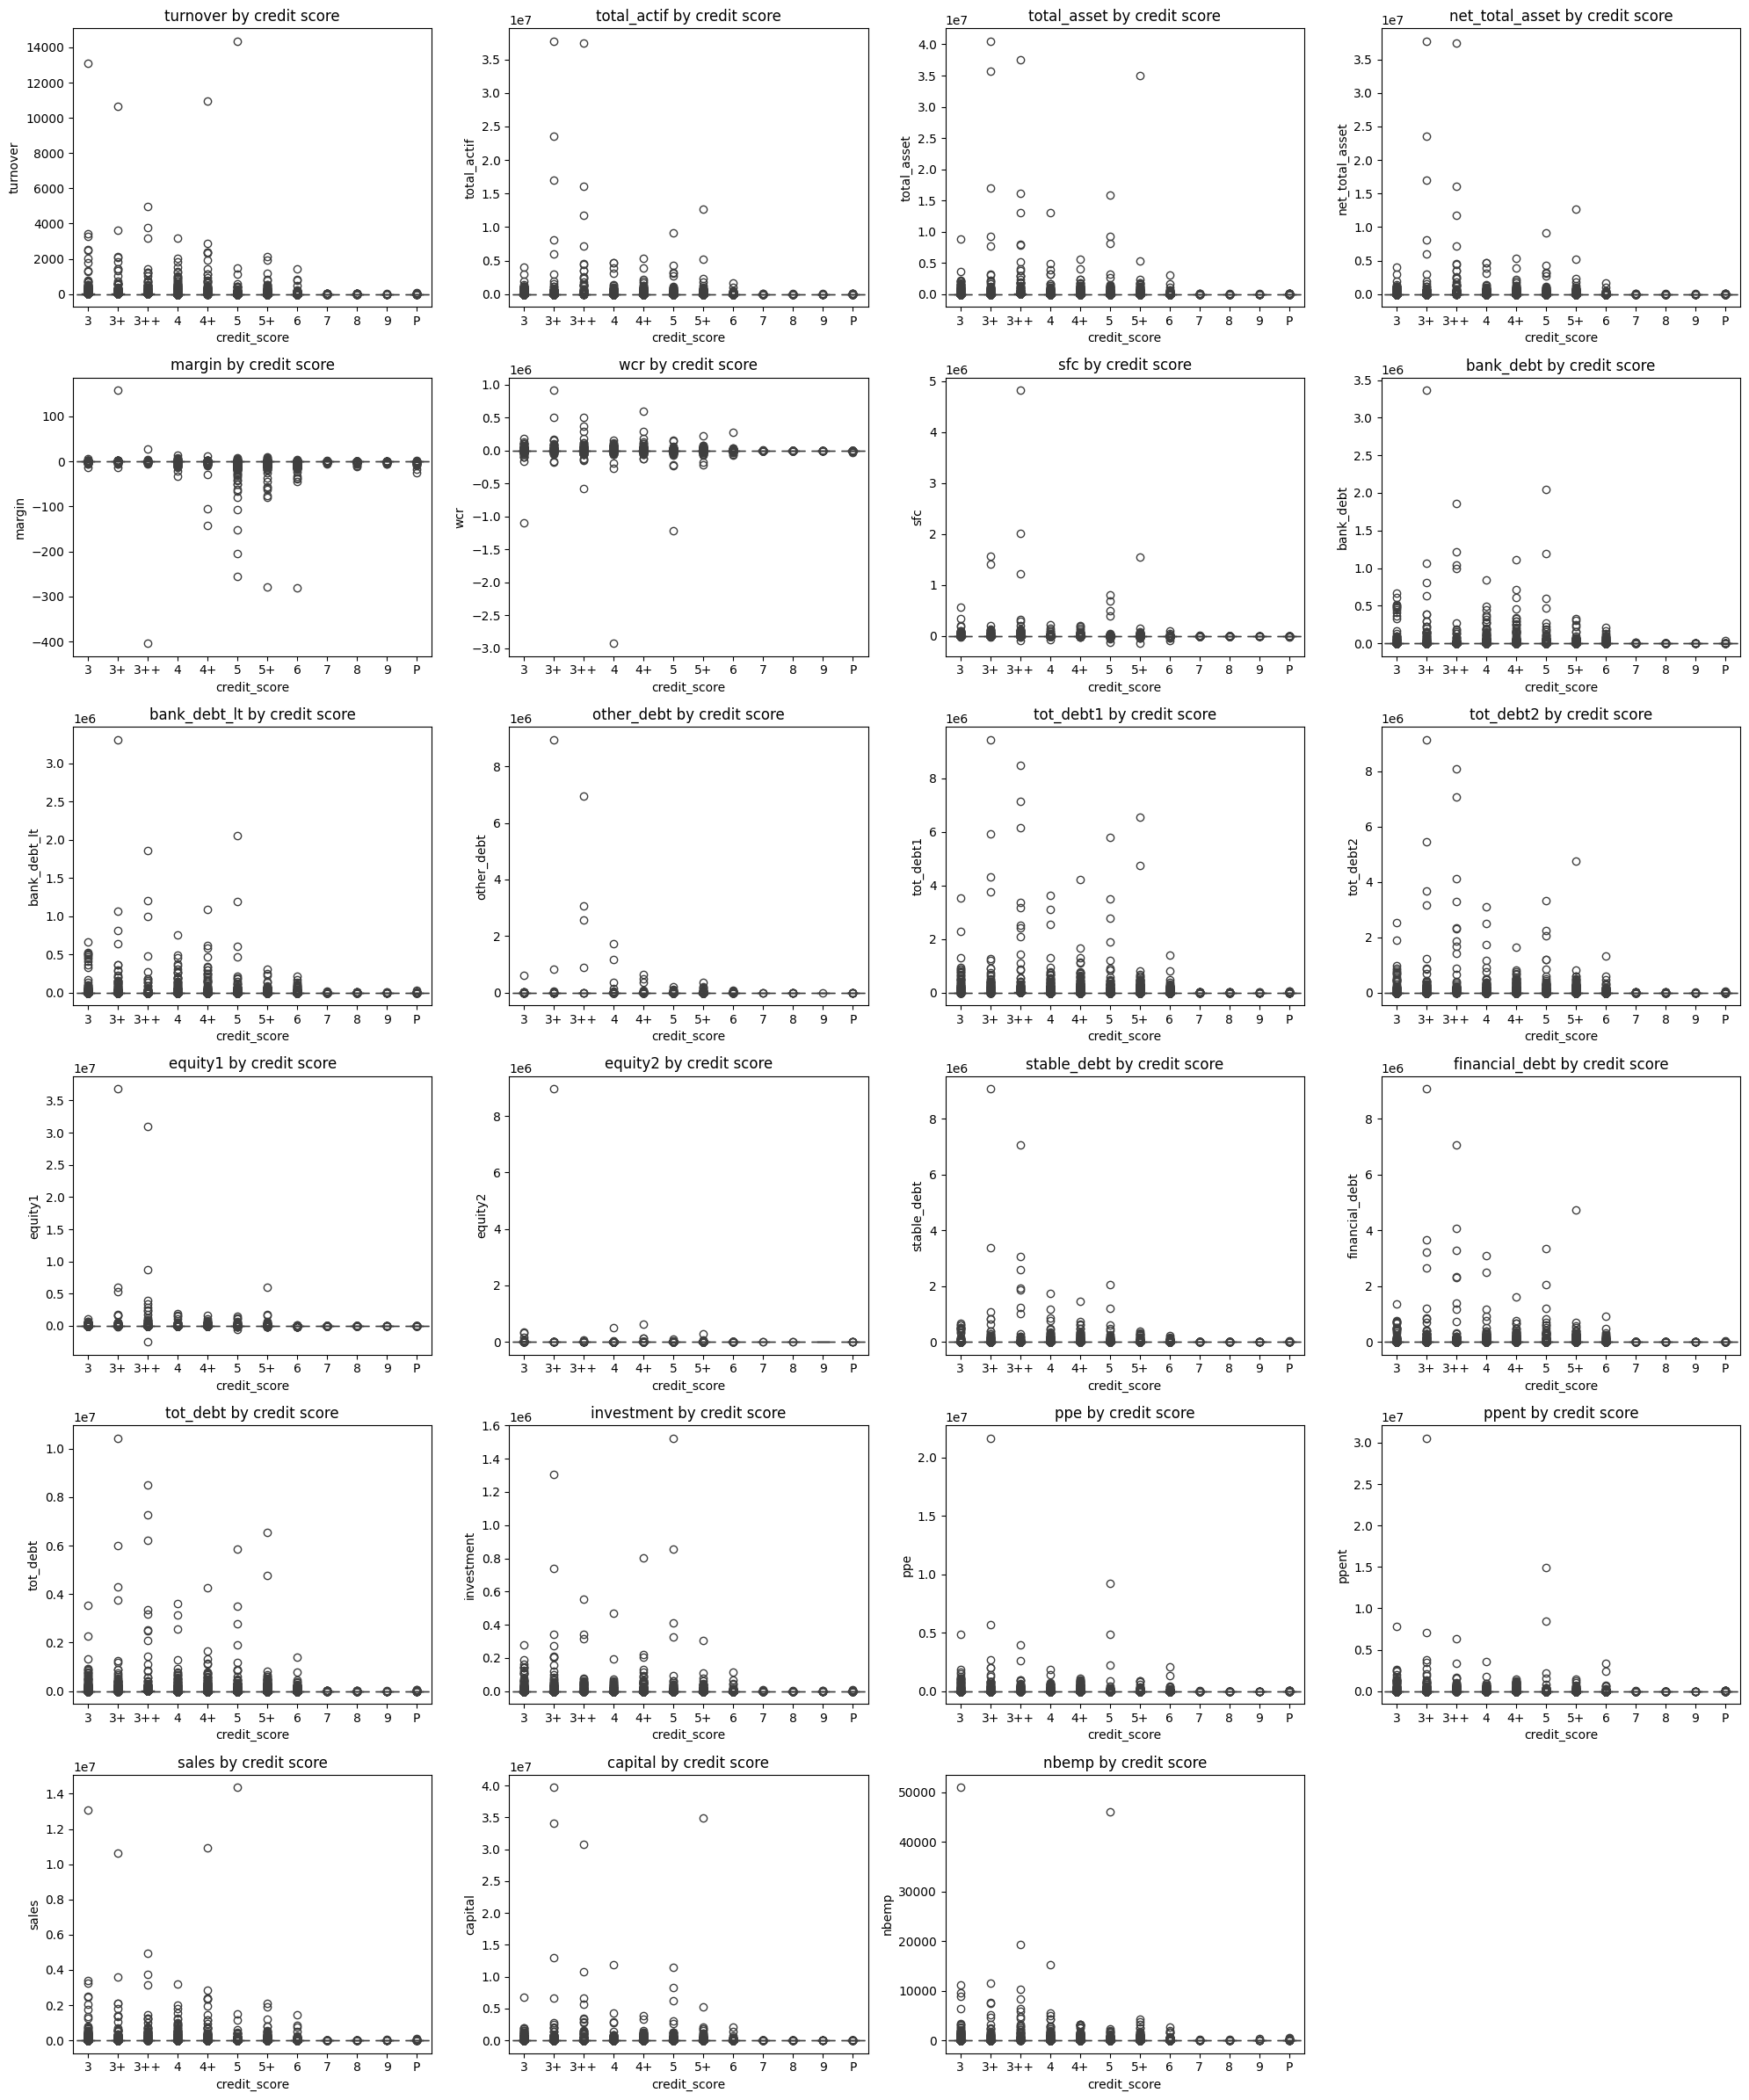

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plot_cols = ['turnover', 'total_actif', 'total_asset', 'net_total_asset', 'margin', 'wcr', 'sfc',
             'bank_debt', 'bank_debt_lt', 'other_debt', 'tot_debt1','tot_debt2', 'equity1',
             'equity2', 'stable_debt', 'financial_debt','tot_debt', 'investment', 'ppe', 'ppent',
             'sales','capital', 'nbemp']

# Set number of columns per row
n_cols = 4
n_rows = -(-len(plot_cols) // n_cols)  

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 4))
axes = axes.flatten()  # flatten 2D array of axes for easy iteration

for i, col in enumerate(plot_cols):
    sns.boxplot(x='credit_score', y=col, data=data_tt, ax=axes[i])
    axes[i].set_title(f'{col} by credit score')

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

We have the following credit scores in the data: '3++', '3+', '3', '4+', '4', '5+', '5','6','7','8','9','P'; where '3++' is the best and 'P' the worst score. 

We found the variable id and intangible to be useless, since id offers no predictive power as it is a descriptor unique to each client, whereas intangible contains all 0 values thus containing no variance and hence giving us no information to help the model differentiate samples.

The boxplots show that most financial variables are highly right-skewed, with a few firms having extremely large values. Variability decreases as credit scores rise: low-score firms (around 3–5) display wide dispersion in assets, debt, and sales, while high-score firms (8–9) show more compact, stable distributions. Debt levels are higher and more volatile among low-score firms, whereas asset and equity measures become more consistent with higher credit ratings. Margins cluster around zero, with slightly better results for higher scores. Overall, firms with stronger credit ratings appear financially steadier and more homogeneous, while those with lower scores are larger, riskier, and more variable.

We chose not to remove outliers as outliers in financial data often represent genuine and important variations in client behavior rather than noise. High-income or high-debt clients may appear as statistical outliers but are real segments of the population that carry valuable predictive information about credit risk.

## Train - Test split

In [134]:
train, test = train_test_split(data_tt, test_size=0.2)

x_train = train.drop('credit_score', axis=1)
y_train = train['credit_score'].astype('string')

x_test = test.drop('credit_score', axis=1)
y_test = test['credit_score'].astype('string')

# Task 2

## Feature Selection

In [ ]:
# Identify categorical and numerical columns 
categorical_cols = ['industry']  # Industry column as categorical
numerical_cols = [col for col in x_train.columns if col not in categorical_cols]  # All other columns as numerical

# Create preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), numerical_cols),
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
        ]), categorical_cols)
    ])

# Create feature selection pipeline
feature_selector = Pipeline([
    ('preprocessor', preprocessor),
    ('selector', SelectFromModel(LogisticRegression(max_iter=1000, random_state=42)))
])

# Fit the feature selector on training data
feature_selector.fit(x_train, y_train)

# Get selected features
selected_features_mask = feature_selector.named_steps['selector'].get_support()

# Get feature names after preprocessing (including one-hot encoded categorical features)
preprocessed_feature_names = (numerical_cols + 
                            list(feature_selector.named_steps['preprocessor']
                                .named_transformers_['cat']
                                .named_steps['onehot']
                                .get_feature_names_out(categorical_cols)))

selected_features = [preprocessed_feature_names[i] for i in range(len(preprocessed_feature_names)) if selected_features_mask[i]]

print(f"Number of selected features: {len(selected_features)}")
print(f"Selected features: {selected_features}")

Number of selected features: 43
Selected features: ['turnover', 'total_actif', 'total_asset', 'net_total_asset', 'margin', 'sfc', 'bank_debt', 'other_debt', 'tot_debt2', 'equity1', 'financial_debt', 'tot_debt', 'ppe', 'ppent', 'sales', 'capital', 'nbemp', 'bank_debt_over_assets', 'industry_1', 'industry_2', 'industry_8', 'industry_11', 'industry_14', 'industry_15', 'industry_16', 'industry_22', 'industry_24', 'industry_31', 'industry_35', 'industry_36', 'industry_43', 'industry_47', 'industry_50', 'industry_51', 'industry_63', 'industry_64', 'industry_66', 'industry_68', 'industry_69', 'industry_75', 'industry_78', 'industry_86', 'industry_93']


## Feature importance

Top 10 Feature Importances (Random Forest - Industry as Categorical):
            feature  importance
14          equity1    0.058318
36   debt_to_equity    0.044021
8               sfc    0.036579
22            sales    0.034779
1          turnover    0.034370
13        tot_debt2    0.032883
23          capital    0.032479
6            margin    0.032397
3       total_actif    0.032201
5   net_total_asset    0.032196


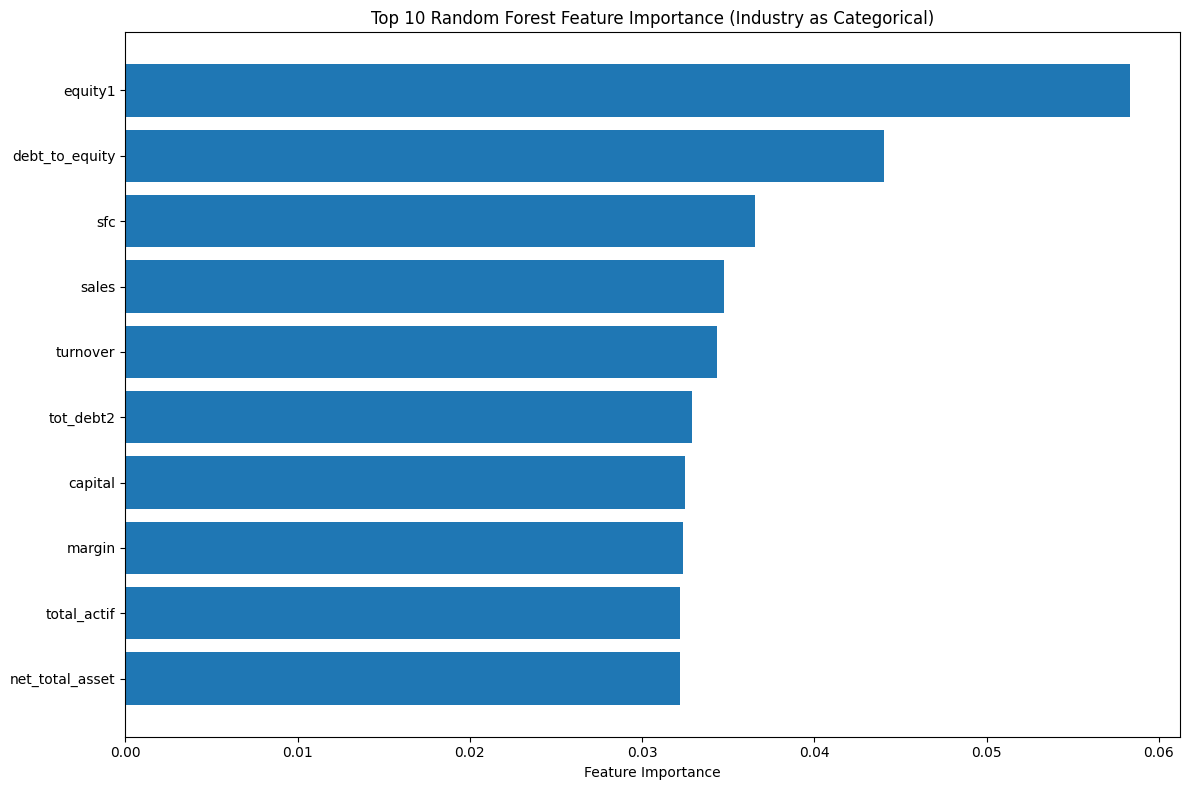

In [70]:
# Random Forest with industry as categorical
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

# Identify categorical and numerical columns (treating industry as categorical)
categorical_cols = ['industry']
numerical_cols = [col for col in x_train.columns if col not in categorical_cols]

# Create preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), numerical_cols),
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
        ]), categorical_cols)
    ])

# Preprocess the training data
x_train_preprocessed = preprocessor.fit_transform(x_train)

# Train Random Forest
rf_categorical = RandomForestClassifier(n_estimators=100, random_state=42)
rf_categorical.fit(x_train_preprocessed, y_train)

# Get feature names after preprocessing (including one-hot encoded categorical features)
preprocessed_feature_names = (numerical_cols + 
                            list(preprocessor.named_transformers_['cat']
                                .named_steps['onehot']
                                .get_feature_names_out(categorical_cols)))

# Get feature importances
feature_importances = rf_categorical.feature_importances_

# Create a dataframe for better visualization
importance_df = pd.DataFrame({
    'feature': preprocessed_feature_names,
    'importance': feature_importances
}).sort_values('importance', ascending=False)

print("Top 10 Feature Importances (Random Forest - Industry as Categorical):")
print(importance_df.head(10))

# Plot top 10 feature importances
plt.figure(figsize=(12, 8))
top_10 = importance_df.head(10)
plt.barh(range(len(top_10)), top_10['importance'].values[::-1])
plt.yticks(range(len(top_10)), top_10['feature'].values[::-1])
plt.xlabel('Feature Importance')
plt.title('Top 10 Random Forest Feature Importance (Industry as Categorical)')
plt.tight_layout()
plt.show()

* ⁠The selector consistently keeps variables from the size/solvency/liquidity families (e.g., total assets/equity/sales/capital, margin, WCR/SFC, debt levels/ratios). That’s expected in credit risk: bigger, better-capitalized, more liquid firms tend to get higher grades.
* ⁠When ⁠ industry ⁠ is one-hot encoded, several industry dummies are also retained → sector effects carry signal, but fundamentals still dominate.
* ⁠Because many financial variables are highly collinear (e.g., ⁠ total_asset ⁠, ⁠ total_actif ⁠, ⁠ sales ⁠, ⁠ capital ⁠), L1/L2 selection can pick different representatives of the same family across runs without meaningfully changing performance. Read it at the family level, not single variables.

Credit grades in this sample are primarily explained by size/solvency/liquidity variables, with industry adding secondary signal; linear feature selection highlights one representative per correlated family, while tree-based importance confirms the same themes with non-linear interactions—interpret results at the family level and stabilize them via CV-averaged permutation/SHAP.

# Task 3

## Predictions

In [137]:
pre = ColumnTransformer([
    ('num', SimpleImputer(strategy='median'), numerical_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols),
])

le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)

xgbc = XGBClassifier(
    objective="multi:softprob",
    num_class=len(le.classes_),
    n_estimators=500,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_lambda=0.6,
    eval_metric="mlogloss",
    tree_method="hist",
    min_child_weight=5
)

model = Pipeline([
    ('preprocessor', pre),
    ('model', xgbc)
])

model.fit(x_train, y_train_enc)
y_pred_enc = model.predict(x_test)
y_pred= le.inverse_transform(y_pred_enc)

In [139]:
grade_order = ['3++', '3+', '3', '4+', '4', '5+', '5','6','7','8','9','P' ]
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred,
                            labels=grade_order,
                            zero_division=0,  # avoid warnings for empty classes
                            target_names=grade_order))

cm = confusion_matrix(y_test, y_pred, labels=grade_order)
tp_per_class = np.diag(cm).astype(int)
tp_per_class

Accuracy: 0.3747
              precision    recall  f1-score   support

         3++       0.34      0.24      0.28       293
          3+       0.27      0.17      0.21       593
           3       0.26      0.19      0.22       881
          4+       0.31      0.26      0.28      1385
           4       0.36      0.53      0.43      2000
          5+       0.45      0.53      0.48      2394
           5       0.32      0.22      0.26      1309
           6       0.46      0.53      0.49       837
           7       0.00      0.00      0.00       101
           8       0.25      0.02      0.04        99
           9       0.00      0.00      0.00        34
           P       0.25      0.09      0.14        74

    accuracy                           0.37     10000
   macro avg       0.27      0.23      0.24     10000
weighted avg       0.36      0.37      0.36     10000



array([  69,  100,  163,  361, 1056, 1257,  288,  444,    0,    2,    0,
          7])

This model performs quite poorly overall, with an accuracy of only 37.5% and a macro-average F1-score of 0.24, indicating weak and inconsistent performance across classes. While some mid-range categories such as 4, 5+, and 6 achieve relatively better F1-scores around 0.43–0.49, most other classes perform very poorly, especially the minority ones like 7, 8, and 9, which have near-zero recall and F1-scores. This suggests the model almost never predicts these classes correctly. The precision and recall values vary widely, implying that the classifier struggles to distinguish between the different labels and likely defaults to predicting the more frequent classes (e.g., “4,” “5+,” “6”). The weighted averages (precision and recall ≈ 0.36–0.37) show that even after accounting for class imbalance, the model’s predictive reliability remains low. Overall, this model appears to be underfitting and heavily biased toward majority categories, failing to generalize across the full label range.

#### Randomized Search CV

In [ ]:
# Preprocessor
pre = ColumnTransformer([
    ('num', SimpleImputer(strategy='median'), numerical_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols),
])

# Encode labels
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

param_dist = {
    "model__n_estimators": randint(200, 1200),
    "model__max_depth": randint(3, 10),
    "model__learning_rate": uniform(0.01, 0.15),
    "model__subsample": uniform(0.7, 0.3),          # 0.7–1.0
    "model__colsample_bytree": uniform(0.7, 0.3),   # 0.7–1.0
    "model__min_child_weight": randint(1, 12),
    "model__reg_lambda": uniform(0.1, 1.2),
}

rnd = RandomizedSearchCV(
    model,
    param_distributions=param_dist,
    n_iter=30,                
    scoring="accuracy",
    cv=3,
    n_jobs=-1,
    verbose=1,
    random_state=42,
)
rnd.fit(x_train, y_train_enc)
best_model = rnd.best_estimator_
y_pred_enc = best_model.predict(x_test)
y_pred = le.inverse_transform(y_pred_enc)

In [21]:
rnd.best_params_

{'model__colsample_bytree': 0.9131988669057362,
 'model__learning_rate': 0.026633623121774697,
 'model__max_depth': 6,
 'model__min_child_weight': 3,
 'model__n_estimators': 774,
 'model__reg_lambda': 1.1749163148082233,
 'model__subsample': 0.8426110669546335}

In [ ]:
grade_order = ['3++', '3+', '3', '4+', '4', '5+', '5','6','7','8','9','P' ]
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred,
                            labels=grade_order,
                            zero_division=0,  
                            target_names=grade_order))

cm = confusion_matrix(y_test, y_pred, labels=grade_order)
tp_per_class = np.diag(cm).astype(int)
tp_per_class

Accuracy: 0.3754
              precision    recall  f1-score   support

         3++       0.36      0.22      0.27       298
          3+       0.22      0.16      0.18       548
           3       0.27      0.18      0.21       893
          4+       0.30      0.26      0.28      1350
           4       0.37      0.51      0.43      2052
          5+       0.44      0.54      0.49      2398
           5       0.33      0.21      0.26      1317
           6       0.46      0.54      0.50       838
           7       0.00      0.00      0.00       107
           8       0.00      0.00      0.00        86
           9       0.00      0.00      0.00        23
           P       0.50      0.12      0.20        90

    accuracy                           0.38     10000
   macro avg       0.27      0.23      0.23     10000
weighted avg       0.36      0.38      0.36     10000



array([  65,   88,  157,  354, 1056, 1289,  278,  456,    0,    0,    0,
         11])

By using Randomized Search CV we obtain a very slight improvement in accuracy.

### Predictions using Data_PCLab5_pred.csv 

In [141]:
data_pred = add_credit_features(data_pred)
data_pred = data_pred.drop(columns=['id', 'intangible'])

In [142]:
pre = ColumnTransformer([
    ('num', SimpleImputer(strategy='median'), numerical_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols),
])


y_hat_enc = model.predict(data_pred)
y_hat = le.inverse_transform(y_hat_enc)
np.savetxt('y_hat.txt', y_hat, fmt='%s')

In [143]:
good_scores = ['4+', '3', '3+', '3++']
count_good = pd.Series(y_hat).isin(good_scores).sum()
percentage_good = (count_good / len(y_hat)) * 100
print(f"Firms with credit score above 4: {count_good} out of {len(y_hat)} ({percentage_good:.2f}%)")

Firms with credit score above 4: 1224 out of 5000 (24.48%)


# Task 4

In [ ]:
# Define bucketing schemes
buckets = {
    # Coarse, good default for "general idea" of risk
    "3bucket": {
        "High Risk":   ['7','8','9','P'],
        "Medium Risk": ['5','5+','6'],
        "Low Risk":    ['3','3+','3++','4','4+']
    },
    # Slightly finer
    "4bucket": {
        "Very High": ['7','8','9','P'],
        "High":      ['5','5+','6'],
        "Medium":    ['4','4+'],
        "Low":       ['3','3+','3++']
    },
    # Collapse to good/bad 
    "binary": {
        "Bad":  ['5+','6','7','8','9','P'],
        "Good": ['3','3+','3++','4','4+','5']
    },
}

def recode_scores(y, scheme):
    groups = buckets[scheme]
    mapping = {g: bucket for bucket, grades in groups.items() for g in grades}
    return pd.Series(y, copy=False).astype(str).map(mapping)


scheme = "3bucket"

y_train_coarse = recode_scores(y_train, scheme)
y_test_coarse  = recode_scores(y_test,  scheme)

In [74]:
pre = ColumnTransformer([
    ('num', SimpleImputer(strategy='median'), numerical_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols),
])

le_2 = LabelEncoder()
y_train_enc_coarse = le_2.fit_transform(y_train_coarse)

xgbc = XGBClassifier(
    objective="multi:softprob",
    num_class=len(le_2.classes_),
    n_estimators=2000,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.9,
    gamma=1.0, 
    reg_lambda=1.0,
    eval_metric="mlogloss",
    tree_method="hist",
    min_child_weight=5,
    random_state=42
)

model = Pipeline([
    ('preprocessor', pre),
    ('model', xgbc)
])

model.fit(x_train, y_train_enc_coarse)
y_pred_enc_enhanced_coarse = model.predict(x_test)
y_pred_enhanced_coarse = le_2.inverse_transform(y_pred_enc_enhanced_coarse)

In [75]:
order_by_scheme = {
    "3bucket": ["High Risk", "Medium Risk", "Low Risk"],
    "4bucket": ["Very High", "High", "Medium", "Low"],
    "binary":  ["Bad", "Good"],
}
print("Accuracy:", accuracy_score(y_test_coarse, y_pred_enhanced_coarse))
print(classification_report(y_test_coarse, y_pred_enhanced_coarse,
                            labels=order_by_scheme[scheme],
                            zero_division=0,  # avoid warnings for empty classes
                            target_names=order_by_scheme[scheme]))

cm = confusion_matrix(y_test_coarse, y_pred_enhanced_coarse, labels=order_by_scheme[scheme])
tp_per_class = np.diag(cm).astype(int)
tp_per_class

Accuracy: 0.7794
              precision    recall  f1-score   support

   High Risk       0.30      0.05      0.09       282
 Medium Risk       0.77      0.75      0.76      4499
    Low Risk       0.79      0.85      0.82      5219

    accuracy                           0.78     10000
   macro avg       0.62      0.55      0.55     10000
weighted avg       0.77      0.78      0.77     10000



array([  14, 3366, 4414])

The model achieves an overall accuracy of about 77.9%, which may seem good at first glance, but the class-wise performance reveals significant imbalance issues. The model performs well for the Medium Risk and Low Risk classes, with F1-scores of 0.76 and 0.82, respectively, and high recall values indicating it identifies these cases effectively. However, the High Risk class shows very poor performance, a precision of 0.30, recall of only 0.05, and an F1-score of 0.09, meaning the model almost entirely fails to capture this critical minority class. This suggests that the classifier is biased toward the majority classes (Medium and Low Risk), likely due to class imbalance (since High Risk has only 282 samples compared to thousands in the other classes). The macro-average F1-score of 0.55 confirms this uneven performance across classes. In short, while the model performs acceptably overall, it’s not reliable for detecting High Risk cases, which could be problematic if those predictions are important.

# Task 5

### Welfare Analysis

In [108]:
# Distance-based weighted accuracy: penalizes predictions based on how far they are from the actual rating
# The further the prediction from the true rating, the worse the penalty

# Define ordinal mapping for credit scores
grade_order = ['3++', '3+', '3', '4+', '4', '5', '5+', '6', '7', '8', '9', 'P']
grade_to_num = {grade: i for i, grade in enumerate(grade_order)}

# Convert to numeric, handling NaN values
y_test_num = pd.Series(y_test).map(grade_to_num).fillna(-1).astype(int)
y_pred_num = pd.Series(y_pred).map(grade_to_num).fillna(-1).astype(int)

# Calculate distance for each prediction
distances = np.abs(y_test_num - y_pred_num)

# Weighted accuracy: penalize by squared distance (quadratic penalty)
weights = 1 / (1 + distances**2)
weighted_accuracy = np.mean(weights)

print("=" * 60)
print("WEIGHTED ACCURACY BASED ON PREDICTION DISTANCE")
print("=" * 60)

print(f"\nStandard Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Weighted Accuracy: {weighted_accuracy:.4f}")
print(f"(Penalizes predictions based on distance from true rating)")

print(f"\nMean Distance: {distances.mean():.2f} grades")
print(f"Max Distance: {int(distances.max())} grades")

# Distance distribution
print("\nDistance Distribution:")
for dist in sorted(distances.unique()):
    if np.isnan(dist):
        continue  # Skip NaN values
    count = (distances == dist).sum()
    pct = (count / len(distances)) * 100
    print(f"  Distance {int(dist)}: {count:4d} cases ({pct:5.2f}%)")

# Critical misclassifications: good firms classified as bad and vice versa
print("\n" + "=" * 60)
print("CRITICAL MISCLASSIFICATIONS")
print("=" * 60)

# Define good/bad firms
good_firms_actual = pd.Series(y_test).isin(['3', '3+', '3++', '4', '4+'])
bad_firms_actual = pd.Series(y_test).isin(['7', '8', '9', 'P'])

good_prediction = pd.Series(y_pred).isin(['3', '3+', '3++', '4', '4+'])
bad_prediction = pd.Series(y_pred).isin(['7', '8', '9', 'P'])

# Good firms denied credit (classified as bad)
good_denied = (good_firms_actual & bad_prediction).sum()
good_denied_pct = (good_denied / good_firms_actual.sum() * 100) if good_firms_actual.sum() > 0 else 0

# Bad firms approved for credit (classified as good)
bad_approved = (bad_firms_actual & good_prediction).sum()
bad_approved_pct = (bad_approved / bad_firms_actual.sum() * 100) if bad_firms_actual.sum() > 0 else 0

print(f"\nGood firms (3-4+) misclassified as bad (7-P):")
print(f"  Cases: {good_denied} out of {good_firms_actual.sum()} ({good_denied_pct:.2f}%)")
print(f"  Impact: Denying credit to viable businesses")

print(f"\nBad firms (7-P) misclassified as good (3-4+):")
print(f"  Cases: {bad_approved} out of {bad_firms_actual.sum()} ({bad_approved_pct:.2f}%)")
print(f"  Impact: Approving risky loans, potential defaults")

print("=" * 60)

WEIGHTED ACCURACY BASED ON PREDICTION DISTANCE

Standard Accuracy: 0.3859
Weighted Accuracy: 0.3639
(Penalizes predictions based on distance from true rating)

Mean Distance: 2.11 grades
Max Distance: 10 grades

Distance Distribution:
  Distance 0:  329 cases ( 1.82%)
  Distance 1:  506 cases ( 2.81%)
  Distance 2:  409 cases ( 2.27%)
  Distance 3:  344 cases ( 1.91%)
  Distance 4:  194 cases ( 1.08%)
  Distance 5:  114 cases ( 0.63%)
  Distance 6:   53 cases ( 0.29%)
  Distance 7:   16 cases ( 0.09%)
  Distance 10:    2 cases ( 0.01%)

CRITICAL MISCLASSIFICATIONS

Good firms (3-4+) misclassified as bad (7-P):
  Cases: 4 out of 5219 (0.08%)
  Impact: Denying credit to viable businesses

Bad firms (7-P) misclassified as good (3-4+):
  Cases: 22 out of 282 (7.80%)
  Impact: Approving risky loans, potential defaults


This output highlights that while the model’s overall accuracy (≈38%) and weighted accuracy (≈36%) suggest limited predictive power, the social implications of its errors are more revealing and concerning.

The model rarely misclassifies good firms (3–4+) as bad (7–P), only 0.08% of cases, which means few viable firms are unfairly denied credit. However, it frequently misclassifies bad firms as good (7.8%), which could result in high-risk loans being approved, leading to potential defaults and broader financial instability. This asymmetry shows that the model’s social harm is concentrated on the side of false positives rather than false negatives.

Overall, while the model performs acceptably in avoiding unfair denial of credit, it poses substantial welfare risks through approving bad firms, indicating a need for cost-sensitive learning or welfare-weighted evaluation rather than accuracy optimization alone.